# 协程

协程是指一个过程，这个过程与调用方协作，产出由调用方提供的值。协程中的关键字 yield 可以视作控制流程的方式。

## 状态

可以使用 `inspect.getgeneratorstate()` 获取协程四个状态中的一个：

- GEN_CREATED：等待开始执行
- GEN_RUNNING：正在执行
- GEN_SUSPENDED：在 yield 表达式处暂停
- GEN_CLOSED：执行结束

## `send` 方法

仅当协程 cr 处于暂停状态才能调用 `send` 方法。如果协程还没激活 (即状态是 GEN_CREATED) ，可以调用 `cr.send(None)` 激活协程，这和使用 `next(cr)` 效果一样。

## 执行过程举例

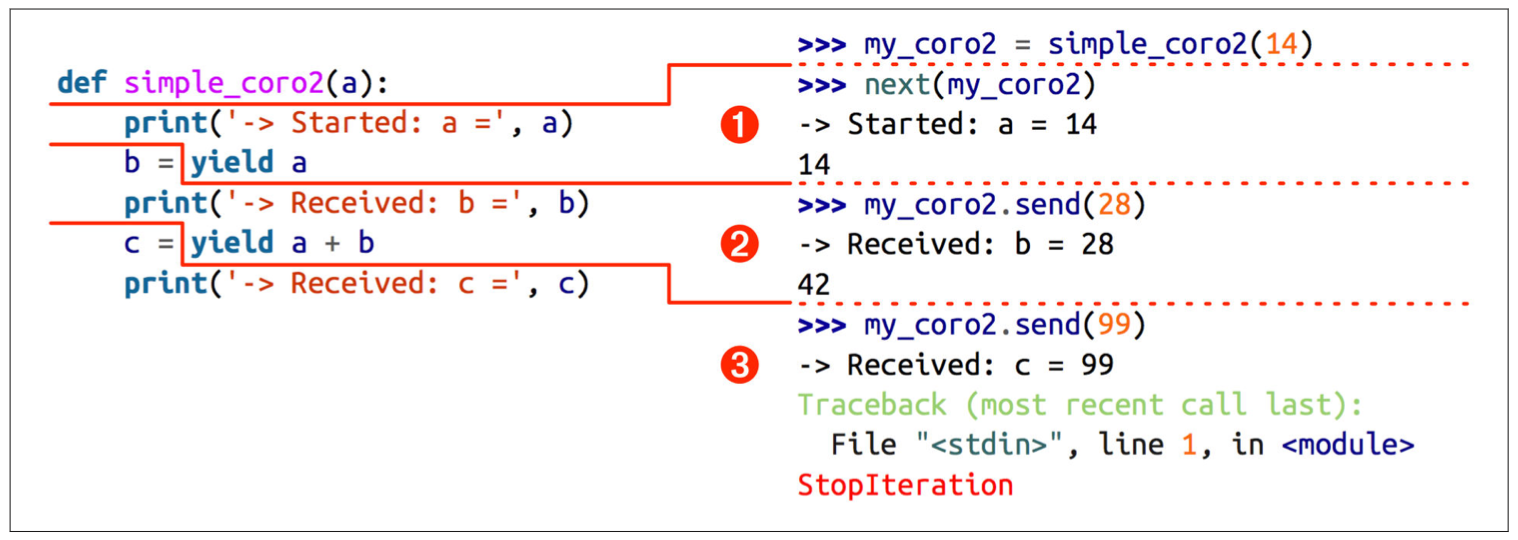

1. 调用 `next(my_coro2)` ，打印第一个消息，然后执行 `yield a` ，产出数字 14
2. 调用 `my_coro2.send(28)` ，把 28 赋值给 b ，打印第二个消息，然后执行 `yield a + b` ，产出 42
3. 调用 `my_coro2.send(99)` ，把 99 赋值给 c ，打印第三个消息，协程终止

注意，各个阶段都在 yield 表达式中结束，而且下一个阶段都从那一行代码开始，然后再把 yield 表达式的值赋给变量。

## 预激 (prime) 协程的装饰器

如果不预激，则协程没什么用，即调用 `send()` 之前，一定要先调用 `next()` 。

有时可以自定义一个预激装饰器以简化协程的用法：

In [1]:
from functools import wraps

def coroutine(func):
    
    @wraps(func)
    def primer(*args, **kwargs):
        gen = func(*args, **kwargs)
        next(gen)
        return gen
    
    return primer

<b style="color: red">注意：</b>
使用 `yield from` 调用协程时，会自动预激，因此与上面的做法不兼容。标准库里的 `asyncio.coroutine` 装饰器不会预激协程，因此可以兼容 `yield from` 语法。

## 终止协程和异常处理

协程中未处理的异常会向上冒泡，传给调用协程的对象，未处理的异常会导致协程终止。

### `generator.throw(exc_type[, exc_value[, traceback]])`

该方法会导致生成器在暂停的 yield 表达式处抛出指定的异常。如果生成器内部处理了该异常，代码会向前执行到下一个 yield 表达式处，而产出的值会成为该方法的返回值。如果生成器内部没有处理这个异常，异常会向上冒泡，传到调用方的上下文中。

### `generator.close()`

该方法使得生成器在暂停的 yield 表达式处抛出 GeneratorExit 异常。如果生成器内部没有处理这个异常，调用方不会报错。如果收到 GeneratorExit 异常，生成器不能产出值，否则解释器会抛出 RuntimeError 异常。

如果不管协程如何结束都需要做清理工作，需要把协程定义体中相关的代码放入 `try/finally` 块中。

## 有返回值的协程

在 Python3.3 之前，如果生成器返回值，解释器会报错。

return 的值会偷偷传给调用方，赋值给 StopIteration 异常的一个属性。这样的做法有点奇怪，但是能保留住生成器对象的常规行为，即耗尽时抛出 StopIteration 异常。

In [2]:
from collections import namedtuple
Result = namedtuple('Result', 'count average')

def averager():
    total = 0.0
    count = 0
    average = None
    while True:
        term = yield
        if term is None:
            break
        total += term
        count += 1
        average = total / count
    return Result(count, average)

In [3]:
c_avg = averager()
next(c_avg)
c_avg.send(10)
c_avg.send(20)
try:
    c_avg.send(None)
except StopIteration as exc:
    result = exc.value
    
result    

Result(count=2, average=15.0)

## `yield from`

在生成器 gen 中使用 `yield from subgen()` 时，subgen 会获得控制权，把产出的值传给 gen 的调用方，即调用方可以直接控制 subgen 。与此同时，gen 会阻塞，等待 subgen 终止。

从定义上来说，`yield from` 的主要功能是打开双向通道，把最外层的调用方与最内层的子生成器连接起来，这样二者可以直接发送和产出值，还可以直接传入异常。

### 结构示意图

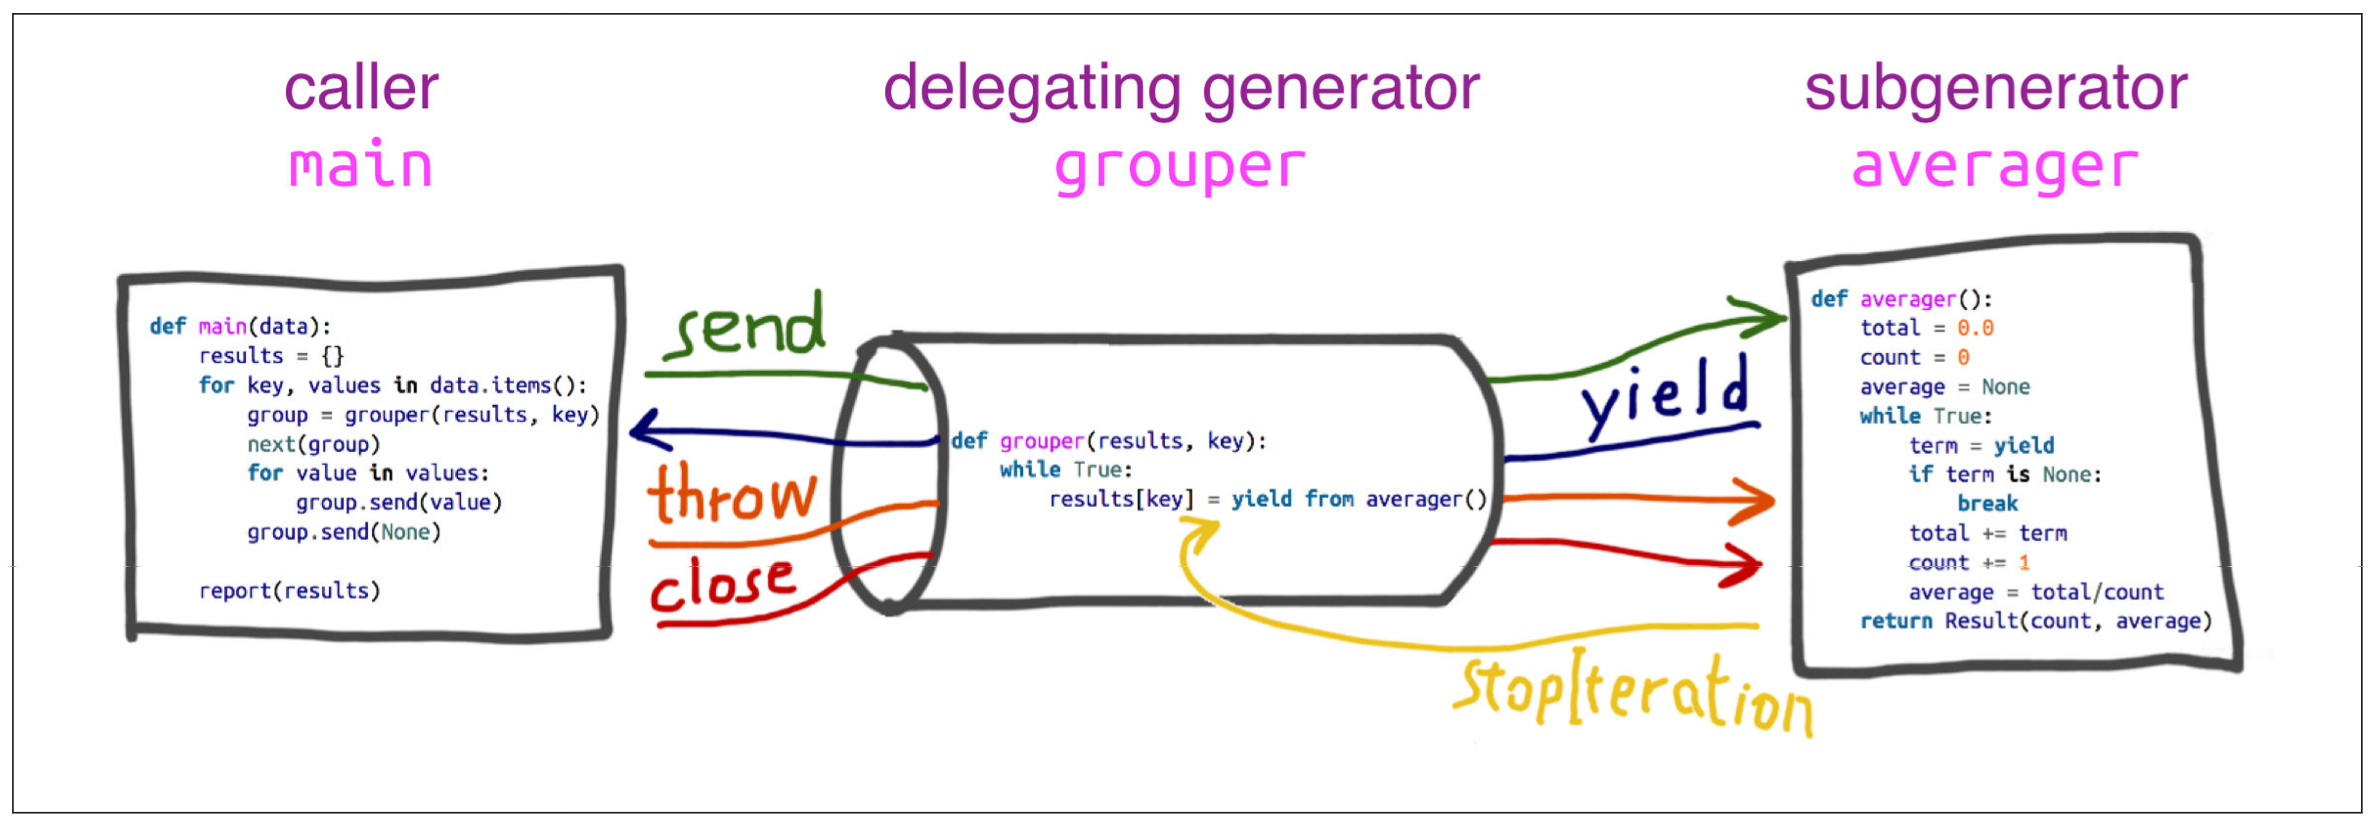

委派生成器在 `yield from` 表达式处暂停时，调用方可以直接把数据发给子生成器，子生成器再把产出的值发给调用方。
子生成器返回之后，解释器抛出 StopIteration 异常，并把返回值附加到异常对象上，届时委派生成器恢复。

委派生成器相当于**管道** ，可以吧任意数量的委派生成器连接在一起，这个管道最终要以一个只使用 yield 表达式的简单生成器结束 (也能以任何可迭代对象结束) 。任何 yield from 链都必须由客户驱动，即在最外层委派生成器上调用 `next()`, `send()` 方法，也可以隐式调用，如使用 for 循环。

### `yield from` 意义

- 子生成器产出的值都直接传给委派生成器的调用方，即客户端
- 使用 `send()` 发给委派生成器的值都直接传给子生成器。如果发送的值是 None ，那么会调用子生成器的 `__next__()` 方法。如果不是 None ，那么会调用子生成器的 `send()` 方法。如果调用的方法抛出 StopIteration 异常，那么委派生成器恢复运行。任何其他异常都会向上冒泡，传给委派生成器
- 生成器退出时，子生成器中的 `return expr` 表达式会触发 `StopIteration(expr)` 异常抛出
- `yield from` 表达式的值是子生成器终止时传给 StopIteration 异常的第一个参数
- 传入委派生成器的异常，除了 GeneratorExit 之外都传给子生成器的 `throw()` 方法。如果调用 `throw()` 方法抛出 StopIteration 异常，委派生成器恢复运行。StopIteration 之外的异常会向上冒泡，传给委派生成器
- 如果把 GeneratorExit 异常传入委派生成器，或者在委派生成器上调用 `close()` 方法，则会在子生成器上调用 `close()` 方法 (如果它有的话) 。如果子生成器调用 `close()` 方法导致异常抛出，则异常会向上冒泡，传给委派生成器，如果没有异常抛出，则委派生成器会抛出 GeneratorExit 异常

#### `RESULT = yield from EXPR` 执行逻辑

In [ ]:
# _i: The subgenerator
# _y: A value yielded from the subgenerator
# _r: The eventual result
# _s: A value sent by the caller to the delegating generator, which is forwarded to the subgenerator
# _e: An exception

_i = iter(EXPR)
try:
    _y = next(_i)
except StopIteration as _e:
    _r = _e.value
else:
    while 1:
        try:
            _s = yield _y
        except GeneratorExit as _e:
            try:
                _m = _i.close
            except AttributeError:
                pass
            else:
                _m()
            raise _e
        except BaseException as _e:
            _x = sys.exc_info()
            try:
                _m = _i.throw
            except AttributeError:
                raise _e
            else:
                try:
                    _y = _m(*_x)
                except StopIteration as _e:
                    _r = _e.value
                    break
        else:
            try:
                if _s is None:
                    _y = next(_i)
                else:
                    _y = _i.send(_s)
            except StopIteration as _e:
                _r = _e.value
                break

RESULT = _r